In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using StatsBase, Distributions, Plots, LinearAlgebra, Plots

In [3]:
using Revise

includet("../src/ESGModels/msvar.jl")
includet("../src/ESGModels/msvar_gibs.jl")
includet("../src/ESGModels/msvar_simulate.jl") 

In [4]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [-.02 .4 .25; .045 .15 .43]
Σ2 = cor2cov([1 .35; .35 1], [.18, .035])

Β = [Β1, Β2]
Σ = [Σ1, Σ2]

transition_matrix = [.98 .02;.05 .95]

states_zero = [.3, .7]
X = [.12, .06]



n_steps = 500
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, Β, Σ, X, n_steps, 1)[:,:,1]'

500×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0897834  0.0312025
  0.0362964  0.0593663
 -0.0625744  0.039583
 -0.0979008  0.0761933
 -0.0394934  0.0494911
  0.0837119  0.00806475
  0.195806   0.0649724
  0.288999   0.100402
  0.296008   0.19051
  0.293367   0.218205
  ⋮          
 -0.207071   0.0404576
 -0.0115493  0.0645848
  0.194324   0.0835756
 -0.0213201  0.171982
  0.0672719  0.0644926
 -0.0275164  0.0481423
 -0.0063276  0.0480784
 -0.0269426  0.0699712
  0.170461   0.0838171

In [5]:
regime_count = count_regime_transitions(test_regimes, 2) 
regime_count ./ sum(regime_count, dims=2)

2×2 Matrix{Float64}:
 0.982955  0.0170455
 0.047619  0.952381

In [6]:
display(count(x -> x==1, test_regimes))
unconditional_regimes(transition_matrix)

353

2-element Vector{Float64}:
 0.7142857142857144
 0.2857142857142857

In [7]:
Y = collect(test_returns[2:end,:])
T = n_steps-1
p = 1
X = hcat(ones(T), test_returns[p:end-1,:])
k= 2 #n_regimes
n_variables = 2
Β = [Β1, Β2]
Σ = [Σ1, Σ2]

2-element Vector{Matrix{Float64}}:
 [0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009]
 [0.0324 0.002205; 0.002205 0.0012250000000000002]

In [8]:
r = 1
display("regime count")
display(count(x -> x==r, test_regimes)/n_steps)

Ym = filter_X(Y, test_regimes[2:end], r)
Xm = filter_X(X, test_regimes[2:end], r)
Beta_mean = inv(Xm' * Xm) * Xm' * Ym
display(Beta_mean') 

display("true beta")
display(Β[r])

"regime count"

0.706

2×3 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0870552  0.277292   0.254039
 0.0311793  0.0760196  0.622883

"true beta"

2×3 Matrix{Float64}:
 0.09  0.3  0.2
 0.03  0.1  0.6

In [9]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)
t_m = zeros(n, 2, 2)

states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
t_m[1, :, :] = sample_transition_matrix(states[1, :], k)

for s in 2:n
    states_zero = unconditional_regimes(t_m[s-1, :, :])
    states[s, :] = simulate_regimes(Y, X, Β, Σ, t_m[s-1, :, :], states_zero)
    t_m[s, :, :] = sample_transition_matrix(states[s, :], k)    
end 

r1 = [count(x -> x ==1, states[:,t]) for t in 1:n_steps-1] / n
display(r1)
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

499-element Vector{Float64}:
 0.979
 0.9898
 0.9894
 0.9858
 0.9868
 0.9912
 0.9918
 0.9956
 0.9982
 0.9986
 ⋮
 0.996
 0.9916
 0.9836
 0.9782
 0.9666
 0.975
 0.9766
 0.9792
 0.9712

"transition matrix"

2×2 Matrix{Float64}:
 0.97791    0.0220901
 0.0490035  0.950997

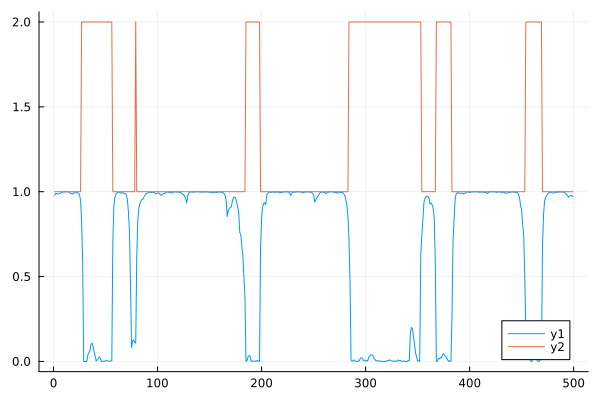

In [10]:
plot(r1)
plot!(test_regimes[2:end])

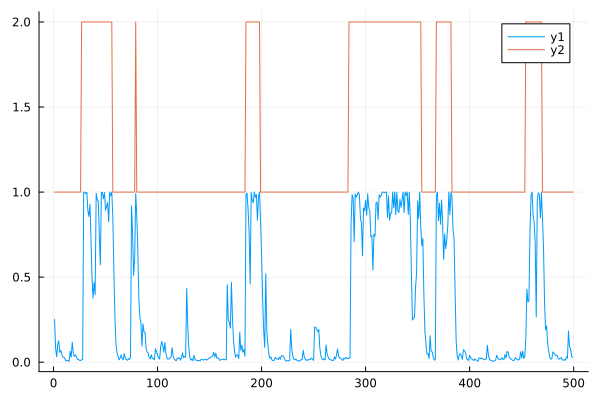

In [11]:
states_zero = [.6, .4]
regimes_probs = hamilton_filter(Y,X, Β, Σ, transition_matrix, states_zero)

plot(regimes_probs[:,2])
plot!(test_regimes[2:end])

In [12]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)


states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
cov_sample = [sample_covariance(Y, X, Β, states[1,:], k)] 

for s in 2:n
    states_zero = unconditional_regimes(transition_matrix)
    states[s, :] = simulate_regimes(Y, X, Β, Σ, transition_matrix, states_zero)
    push!(cov_sample, sample_covariance(Y, X, Β, states[s,:], k))    
end 

cov1_mean = mean(map(x -> x[1], cov_sample))
cov2_mean = mean(map(x -> x[2], cov_sample))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.07748950510932805
 0.030765342815524118

"regime two"

2-element Vector{Float64}:
 0.18818730466381434
 0.032507645149555356

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.248167
 0.248167  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.360438
 0.360438  1.0

In [13]:
n_burn = 20_000
n_sample = 2000
n = 2
Β0 = (inv(transpose(X) * X) * transpose(X) * Y)
Σ0 = transpose((Y -  X * Β0)) * (Y -  X * Β0) / (T- n -1)

tm0 = [.9 .1; .1 .9]

regimes, t_m, Β_post, Σ_post = msvar(Y, X, transition_matrix, [Β0', Β0'], [Σ0, Σ0], n_burn, n_sample)

([1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [0.9725085875573303 0.08135978658693188; 0.9749709770583637 0.06868207378291967; … ; 0.9577866327658804 0.068811438903131; 0.9822077787081169 0.05476281906859763;;; 0.027491412442669724 0.918640213413068; 0.025029022941636427 0.9313179262170803; … ; 0.042213367234119704 0.931188561096869; 0.01779222129188308 0.9452371809314023], Vector{Any}[[[0.07639390766496681 0.23606825610563398 0.4000757615198098; 0.025806265585174643 0.04944574475661414 0.7013456655423236], [-0.04834370294614007 0.25620299648105255 0.7471675102606551; 0.04226971587717323 0.15390067965481669 0.4759339953112163]], [[0.07724901414148642 0.28629165075194396 0.30518851661521057; 0.03349745723340277 0.058121996968873976 0.632044210490054], [-0.08733667401480161 0.2139019556181116 1.2832222117392709; 0.03920506578328996 0.15287287065735086 0.4771881460054012]], [[0.07913044651556789 0.27648096571123365 0.3056629187346401; 0.028029696303285914 0.0889613946127501 0.6235548

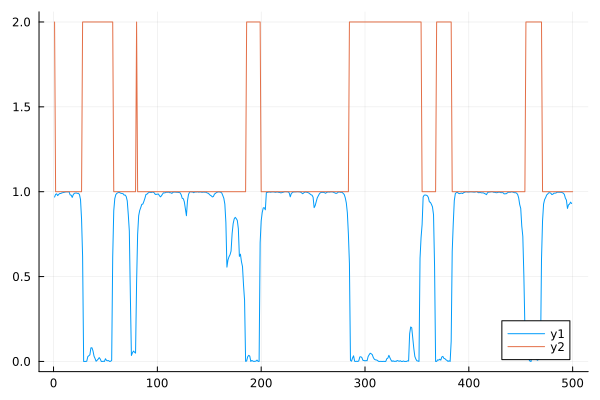

In [14]:
r1 = [count(x -> x ==1, regimes[:,t]) for t in 1:n_steps-1] / n_sample

plot(r1)
plot!(test_regimes)

In [15]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"transition matrix"

2×2 Matrix{Float64}:
 0.975033  0.0249669
 0.052146  0.947854

"coefficients"

"regime one"

2×3 Matrix{Float64}:
 0.086932   0.271646   0.263663
 0.0319286  0.0611749  0.633682

"regime two"

2×3 Matrix{Float64}:
 -0.0558928  0.256036  0.841837
  0.045048   0.160935  0.431508

"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.07674856769041707
 0.030858796699020016

"regime two"

2-element Vector{Float64}:
 0.18626473879219752
 0.03225970302397748

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.244992
 0.244992  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.374485
 0.374485  1.0

In [17]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [.05 .35 .29; .06 .12 .5]
Σ2 = cor2cov([1 .4; .4 1], [.1, .04])
Β3 = [-.02 .4 .25; .045 .15 .43]
Σ3 = cor2cov([1 .35; .35 1], [.18, .035])

Β = [Β1, Β2, Β3]
Σ = [Σ1, Σ2, Σ3]

transition_matrix = [.95 .02 .03;.03 .92 .05;.03 .03 .94;]

states_zero = [.3, .1, .6]
X = [.12, .06]

n_steps = 600
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, Β, Σ, X, n_steps, 1)[:,:,1]'

600×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0737648   0.087277
  0.0949844   0.0573264
  0.265657    0.169979
  0.314296    0.237415
  0.118864    0.201512
  0.0769734   0.171973
  0.159636    0.147561
  0.0711038   0.0533369
  0.0140481   0.0976202
 -0.0196119   0.0719811
  ⋮          
 -0.0145666   0.0999309
  0.0743424   0.0902822
 -0.218339    0.104183
 -0.186982    0.096147
 -0.344558    0.0335974
 -0.203059    0.0509909
 -0.372132   -0.0349384
 -0.553791    0.00404916
 -0.225766   -0.0190567

In [18]:
Y = collect(test_returns[2:end,:])
T = n_steps-1
p = 1
X = hcat(ones(T), test_returns[p:end-1,:])
k= 2 #n_regimes
n_variables = 2


2

In [19]:
n_burn = 20_000
n_sample = 2000
n = 2
Β0 = (inv(transpose(X) * X) * transpose(X) * Y)
Σ0 = transpose((Y -  X * Β0)) * (Y -  X * Β0) / (T- n -1)

tm0 = [.9 .1; .1 .9]

regimes, t_m, Β_post, Σ_post = msvar(Y, X, transition_matrix, [Β0', Β0', Β0'], [Σ0, Σ0, Σ0], n_burn, n_sample)

singular exeption, length Y 1


SingularException: SingularException(2)

In [76]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))
display("regime three")
display(mean(map(x -> x[3],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))
cov3_mean = mean(map(x -> x[3], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))
display("regime three")
display(sqrt.(diag(cov3_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))
display("regime three")
display(cov2cor(cov3_mean))

"transition matrix"

3×3 Matrix{Float64}:
 0.985797     0.0141937    9.57484e-6
 0.000280894  0.000277218  0.999442
 0.0267129    4.82006e-5   0.973239

"coefficients"

"regime one"

2×3 Matrix{Float64}:
 -0.0129703  0.377944  0.231895
  0.0422769  0.144657  0.492206

"regime two"

2×3 Matrix{Float64}:
 0.012179   -2.27328   3.58773
 0.0385408  -0.391658  0.838922

"regime three"

2×3 Matrix{Float64}:
 0.0886271  0.253435  0.172834
 0.0186916  0.107038  0.686164

"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.16927369573215514
 0.03771193190360137

"regime two"

2-element Vector{Float64}:
 0.01343710760847996
 0.00041909246661585666

"regime three"

2-element Vector{Float64}:
 0.08279457833495776
 0.03193836816271248

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.361309
 0.361309  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.905884
 0.905884  1.0

"regime three"

2×2 Matrix{Float64}:
 1.0       0.290329
 0.290329  1.0

In [15]:
using Test
regimes = [1 2 2 1 1]
n_regimes = 2
result = evaluate_all_regimes_sampled(regimes, n_regimes)
@test result == true

regimes = [1 1 1 1 1]
n_regimes = 2
result = evaluate_all_regimes_sampled(regimes, n_regimes)
@test result == false

regimes = [1 2 3 3 1]
n_regimes = 3
result = evaluate_all_regimes_sampled(regimes, n_regimes)
@test result == true

regimes = [1 2 2 1 1]
n_regimes = 3
result = evaluate_all_regimes_sampled(regimes, n_regimes)
@test result == false

Test Passed

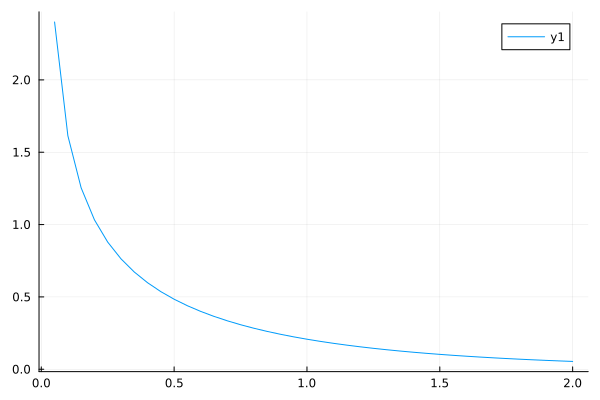

In [53]:
x = .05:.05:2
dist = [pdf(Gamma(0.5,1), r) for r in x]

plot(x, dist)